## Machine Learning - Lab 07 - Decision Tree and Random Forest

* Full name: Đinh Anh Huy
* Student ID: 18110103

In [1]:
import numpy as np
import math
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import progressbar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### Bài tập 1.
**Hãy thử thay đổi Max_depth để tăng accuracy trên tập testing, vẽ cây với Max_depth đã thay đổi.**

In [2]:
path = "https://raw.githubusercontent.com/huynhthanh98/ML/master/lab-07/bt1.csv"
data = pd.read_csv(path, header=None)

col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data.columns = col_names
print("Shape of data: ", data.shape)
data.head()

Shape of data:  (1728, 7)


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
# Check missing values
data.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [4]:
X = data.drop("class", axis=1)
y = data["class"]


encoder = LabelEncoder()
data_colums = X.dtypes.pipe(lambda X: X[X=='object']).index
for col in data_colums:
    X[col] = encoder.fit_transform(X[col])
    
X.head()

,buying,maint,doors,persons,lug_boot,safety
0,3,3,0,0,2,1
1,3,3,0,0,2,2
2,3,3,0,0,2,0
3,3,3,0,0,1,1
4,3,3,0,0,1,2


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("Shape of training set: ", X_train.shape)
print("Shape of testing set: ", X_test.shape)

Shape of training set:  (1157, 6)
Shape of testing set:  (571, 6)


In [6]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state=0, max_features=None)
model.fit(X_train, y_train)
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
print('Model accuracy score on training set: {0:0.4f}'.format(acc_train))
print('Model accuracy score on testing set: {0:0.4f}'.format(acc_test))

Model accuracy score on training set: 0.9991
Model accuracy score on testing set: 0.9720


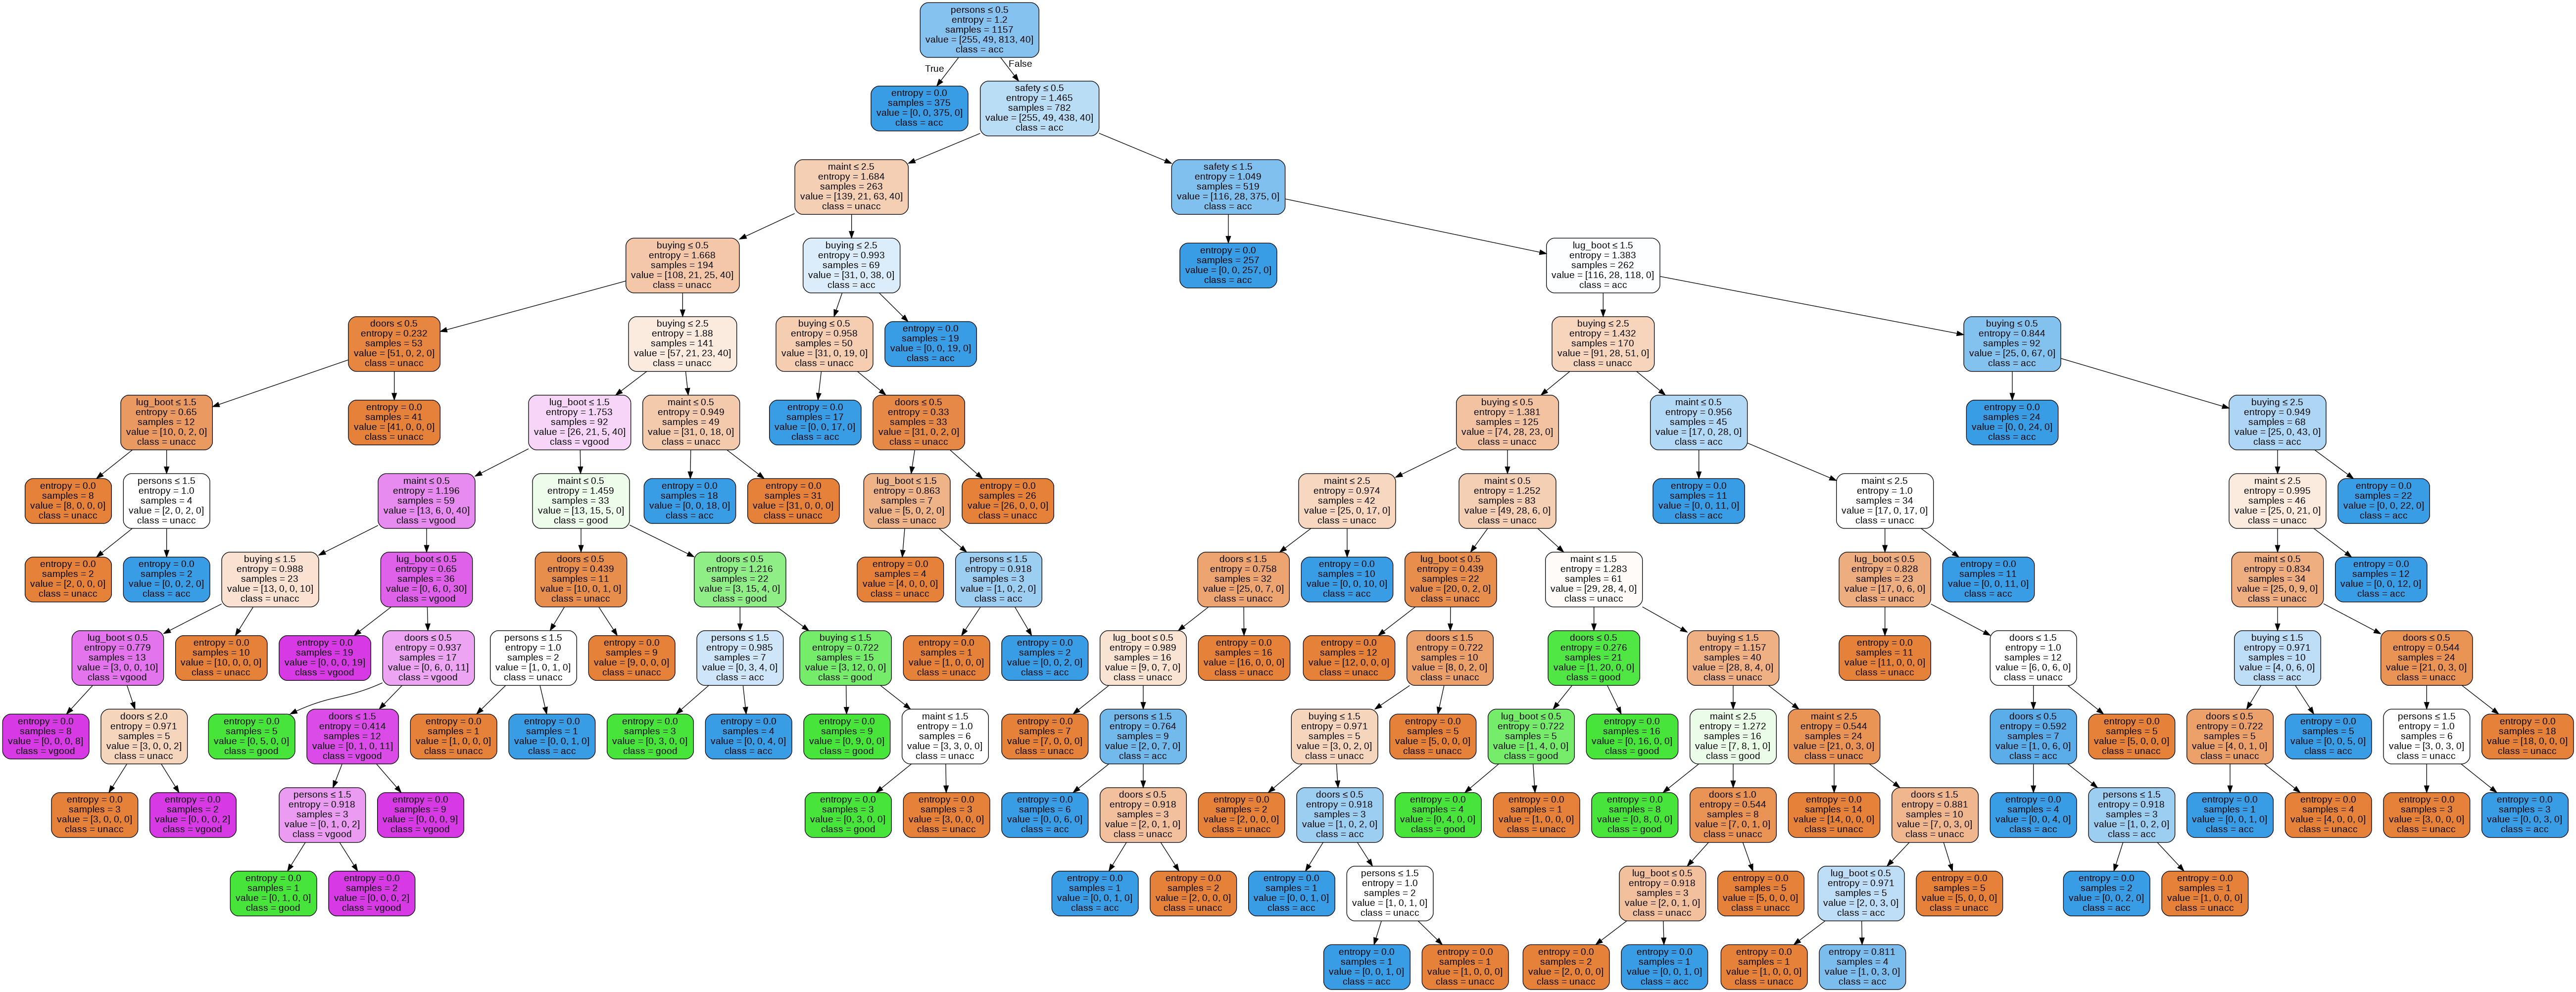

In [7]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X_train.columns,class_names=list(y_train.unique()))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

### Bài tập 2.
**`max_depth` ảnh hưởng như thế nào đối với mô hình decision tree? Vì sao?**

`max_depth` được hiểu là độ sâu tối đa của decision tree. Nhìn chung, decision tree có xu hướng phát triển về độ sâu để có thể đưa ra quyết định tốt nhất cho mô hình với accuracy cao. Tuy nhiên, do xu hướng phát triển càng sâu khiến cho quyết định trở nên càng cụ thể và phức tạp hơn, dễ khiến mô hình bị overfit. Do đó, khi `max_depth` quá lớn, sẽ dẫn đến tình trạng overfitting, khiến cho mô hình mặc dù cho kết quả tốt trên tập training nhưng đối với dữ liệu mới trên tập testing lại cho ra kết quả dự đoán không tốt.

### Bài tập 3
**Dùng dataset bên dưới, từ mô hình Decision Tree hãy code thêm mô hình Random Forest như thuật toán đã học. Thử tìm hiểu cách dùng Random Forest trong sklearn để so sánh kết quả.**

In [8]:
class RandomForest:
  def __init__(self, n_estimators=100, max_features='auto', min_samples_split=2,
               max_depth=None, random_state=None, criterion='gini'):
    self.n_estimators = n_estimators    # Number of trees
    self.max_features = max_features    # Maxmimum number of features per tree
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth          # Maximum depth for tree
    self.random_state = random_state
    self.criterion = criterion
    self.decision_trees = []
    # Set random seed
    if random_state is None:
      np.random.seed(0)
    else:
      np.random.seed(self.random_state)

  @staticmethod
  def _sample(X, y):
    n_samples = X.shape[0]
    # Concatenate x and y and do a random shuffle
    X_y = np.concatenate((X, np.array(y).reshape(-1,1)), axis=1)
    np.random.shuffle(X_y)

    idx = np.random.choice(a=n_samples, size=n_samples, replace=True)
    X = X_y[idx][:, :-1]
    y = X_y[idx][:, -1]
    return X, y

  def fit(self, X, y):
    if len(self.decision_trees) > 0:
      self.decision_trees = []

    n_features = X.shape[1]

    for i in range(self.n_estimators):
      # Get a random subset of the data for each tree
      X_subset, y_subset = self._sample(X, y)
      # Fit the tree to the data
      clf = DecisionTreeClassifier(criterion=self.criterion,
                                   min_samples_split=self.min_samples_split, 
                                   max_depth=self.max_depth, 
                                   max_features=self.max_features, 
                                   random_state=self.random_state)
      clf.fit(X_subset, y_subset)
      # Save the classifier
      self.decision_trees.append(clf)

  def predict(self, X):
    X = np.array(X)
    y_preds = np.empty((X.shape[0], len(self.decision_trees)))

    # Let each tree make a prediction on the data
    for i, tree in enumerate(self.decision_trees):
      prediction = tree.predict(X)
      y_preds[:, i] = prediction
        
    y_pred = []
    # For each sample
    for sample_predictions in y_preds:
      # Select the most common class prediction
      y_pred.append(np.bincount(sample_predictions.astype('int')).argmax())
    return np.array(y_pred).reshape(1,-1)

  def score(self, X, y):
    from sklearn.metrics import accuracy_score
    return accuracy_score(np.array(y), self.predict(X).reshape(-1,1))

In [9]:
path = "https://raw.githubusercontent.com/huynhthanh98/ML/master/lab-07/bt2.csv"
data = pd.read_csv(path)
print("Shape of data: ", data.shape)
data.head()

Shape of data:  (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
# Check missing values
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [11]:
# Check type of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [12]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print("Shape of training set: ", X_train.shape)
print("Shape of testing set: ", X_test.shape)

Shape of training set:  (537, 8)
Shape of testing set:  (231, 8)


In [13]:
model = RandomForest(n_estimators=1000, max_depth=10, random_state=16, criterion='entropy')
model.fit(X_train, y_train)
prediction = model.predict(X_test)
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
print('Model accuracy score on training set: {0:0.4f}'.format(acc_train))
print('Model accuracy score on testing set: {0:0.4f}'.format(acc_test))
print('Prediction: \n', prediction)


Model accuracy score on training set: 0.9832
Model accuracy score on testing set: 0.7965
Prediction: 
 [[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1
  0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1
  0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1
  1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0
  1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]]


**Thực thi Random Forest bằng thư viện scikit-learn**

In [14]:
clf = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=10, random_state=16)
clf.fit(X_train, y_train)
pred_skl = clf.predict(X_test)
acc_train_skl = clf.score(X_train, y_train)
acc_test_skl = clf.score(X_test, y_test)
print('Model accuracy score on training set: {0:0.4f}'.format(acc_train_skl))
print('Model accuracy score on testing set: {0:0.4f}'.format(acc_test_skl))
print('Prediction: \n', pred_skl)
clf.score(X_train, y_train)

Model accuracy score on training set: 0.9944
Model accuracy score on testing set: 0.7965
Prediction: 
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0
 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0
 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0]


0.994413407821229